In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


Load in the data

Decision Tree on revised date times

Aggregate Demographic data

In [2]:
file_path = 'C:\\Users\\User\\Desktop\\Data STAT 451\\Divvy_Trips_20240730.csv'  # Replace with the actual file path based on who is using script
df = pd.read_csv(file_path)

# Convert time columns to datetime
df['START TIME'] = pd.to_datetime(df['START TIME'], format='%m/%d/%Y %I:%M:%S %p')
df['STOP TIME'] = pd.to_datetime(df['STOP TIME'], format='%m/%d/%Y %I:%M:%S %p')
# Calculate age
current_year = pd.Timestamp.now().year
df['AGE'] = current_year - df['BIRTH YEAR']
# Filter out unrealistic ages
df = df[(df['AGE'] > 0) & (df['AGE'] < 100)]
# Create inflow and outflow events
outflows = df[['START TIME', 'FROM STATION ID', 'USER TYPE', 'GENDER', 'AGE']].copy()
outflows['OUTFLOW'] = 1
outflows.rename(columns={'START TIME': 'TIME', 'FROM STATION ID': 'STATION ID'}, inplace=True)
inflows = df[['STOP TIME', 'TO STATION ID', 'USER TYPE', 'GENDER', 'AGE']].copy()
inflows['INFLOW'] = 1
inflows.rename(columns={'STOP TIME': 'TIME', 'TO STATION ID': 'STATION ID'}, inplace=True)
# Merge inflows and outflows
events = pd.merge(inflows, outflows, on=['TIME', 'STATION ID', 'USER TYPE', 'GENDER', 'AGE'], how='outer')
events['INFLOW'] = events['INFLOW'].fillna(0)
events['OUTFLOW'] = events['OUTFLOW'].fillna(0)
# Ensure INFLOW and OUTFLOW columns are integers
events['INFLOW'] = events['INFLOW'].astype(int)
events['OUTFLOW'] = events['OUTFLOW'].astype(int)
# Calculate cumulative flows
events.sort_values(by=['STATION ID', 'TIME'], inplace=True)
events['CUMULATIVE INFLOW'] = events.groupby(['STATION ID', 'USER TYPE', 'GENDER', 'AGE'])['INFLOW'].cumsum()
events['CUMULATIVE OUTFLOW'] = events.groupby(['STATION ID', 'USER TYPE', 'GENDER', 'AGE'])['OUTFLOW'].cumsum()
events['NET FLOW'] = events['CUMULATIVE INFLOW'] - events['CUMULATIVE OUTFLOW']
# Daily aggregation
events['DATE'] = events['TIME'].dt.date
daily = events.groupby(['STATION ID', 'DATE', 'USER TYPE', 'GENDER', 'AGE']).agg({
    'INFLOW': 'sum',
    'OUTFLOW': 'sum',
    'NET FLOW': 'sum'
}).reset_index()
def determine_status(net_flow):
    if net_flow > 0:
        return 'OVERFLOW'
    elif net_flow < 0:
        return 'UNDERFLOW'
    else:
        return 'BALANCED'
daily['STATUS'] = daily['NET FLOW'].apply(determine_status)
# Save the aggregated data to a new CSV file (Not neccesary for all users, uncomment if curious)
#daily.to_csv('aggregated_flow_demographics_with_status.csv', index=False)
print(daily.head())


   STATION ID        DATE   USER TYPE  GENDER   AGE  INFLOW  OUTFLOW  \
0           2  2015-05-08  Subscriber    Male  49.0       0        1   
1           2  2015-05-09  Subscriber  Female  37.0       0        1   
2           2  2015-05-09  Subscriber  Female  49.0       2        0   
3           2  2015-05-09  Subscriber    Male  35.0       0        1   
4           2  2015-05-09  Subscriber    Male  39.0       1        0   

   NET FLOW     STATUS  
0      -1.0  UNDERFLOW  
1      -1.0  UNDERFLOW  
2       3.0   OVERFLOW  
3      -1.0  UNDERFLOW  
4       1.0   OVERFLOW  


In [3]:
def mode(series):
    return series.mode()[0]
numeric_columns = daily.select_dtypes(include=[float, int]).columns
categorical_columns = daily.select_dtypes(include=[object]).columns
df_avg_mode = daily.groupby('STATION ID').agg({**{col: 'mean' for col in numeric_columns if col != 'STATION ID'},
                                               **{col: mode for col in categorical_columns if col != 'STATION ID'}}).reset_index()
# Second DataFrame: Mean for numeric, proportion for classification ones
# We will use the same numeric columns, but handle categorical columns differently, ultimately, this dataframe went unused; however, it tells a story of my thought process and i thought it aatleast valuable to keep as a memoir or reference to my methods
daily['USER TYPE'] = daily['USER TYPE'].astype('category')
daily['GENDER'] = daily['GENDER'].astype('category')
user_type_dummies = pd.get_dummies(daily['USER TYPE'], prefix='USER TYPE')
gender_dummies = pd.get_dummies(daily['GENDER'], prefix='GENDER')
df_with_dummies = pd.concat([daily, user_type_dummies, gender_dummies], axis=1)
proportion_columns = user_type_dummies.columns.tolist() + gender_dummies.columns.tolist()
df_mean_proportion = df_with_dummies.groupby('STATION ID').agg({**{col: 'mean' for col in numeric_columns if col != 'STATION ID'},
                                                                **{col: 'mean' for col in proportion_columns}}).reset_index()


print("DataFrame with averages and modes:")
print(df_avg_mode.head())

print("\nDataFrame with means and proportions:")
print(df_mean_proportion.head())


DataFrame with averages and modes:
   STATION ID        AGE    INFLOW   OUTFLOW   NET FLOW        DATE  \
0           2  42.833612  0.734134  0.869415 -24.660177  2019-05-05   
1           3  43.328069  0.961244  0.956211  10.494924  2019-08-10   
2           4  43.627278  1.364677  1.394898  -9.582853  2019-07-13   
3           5  45.599758  0.848972  0.830240  42.546130  2019-09-16   
4           6  44.899707  0.954757  0.914917  25.455417  2019-08-03   

    USER TYPE GENDER     STATUS  
0  Subscriber   Male  UNDERFLOW  
1  Subscriber   Male   OVERFLOW  
2  Subscriber   Male  UNDERFLOW  
3  Subscriber   Male   OVERFLOW  
4  Subscriber   Male   OVERFLOW  

DataFrame with means and proportions:
   STATION ID        AGE    INFLOW   OUTFLOW   NET FLOW  USER TYPE_Customer  \
0           2  42.833612  0.734134  0.869415 -24.660177            0.181159   
1           3  43.328069  0.961244  0.956211  10.494924            0.199855   
2           4  43.627278  1.364677  1.394898  -9.582853   

testing classifier tree code

In [4]:
X = df_avg_mode.drop(columns=['STATUS', 'STATION ID', 'DATE', 'INFLOW', 'OUTFLOW', 'NET FLOW'])  
y = df_avg_mode['STATUS']
label_encoders = {}
for column in X.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# Display results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

    OVERFLOW       0.68      0.92      0.78        78
   UNDERFLOW       0.70      0.29      0.41        48

    accuracy                           0.68       126
   macro avg       0.69      0.61      0.60       126
weighted avg       0.69      0.68      0.64       126



Now, we will do this while oversampling Customer, a huge minority class in USER TYPE variable. Doing this will ensure model robustness.

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

    OVERFLOW       0.68      0.92      0.78        78
   UNDERFLOW       0.70      0.29      0.41        48

    accuracy                           0.68       126
   macro avg       0.69      0.61      0.60       126
weighted avg       0.69      0.68      0.64       126



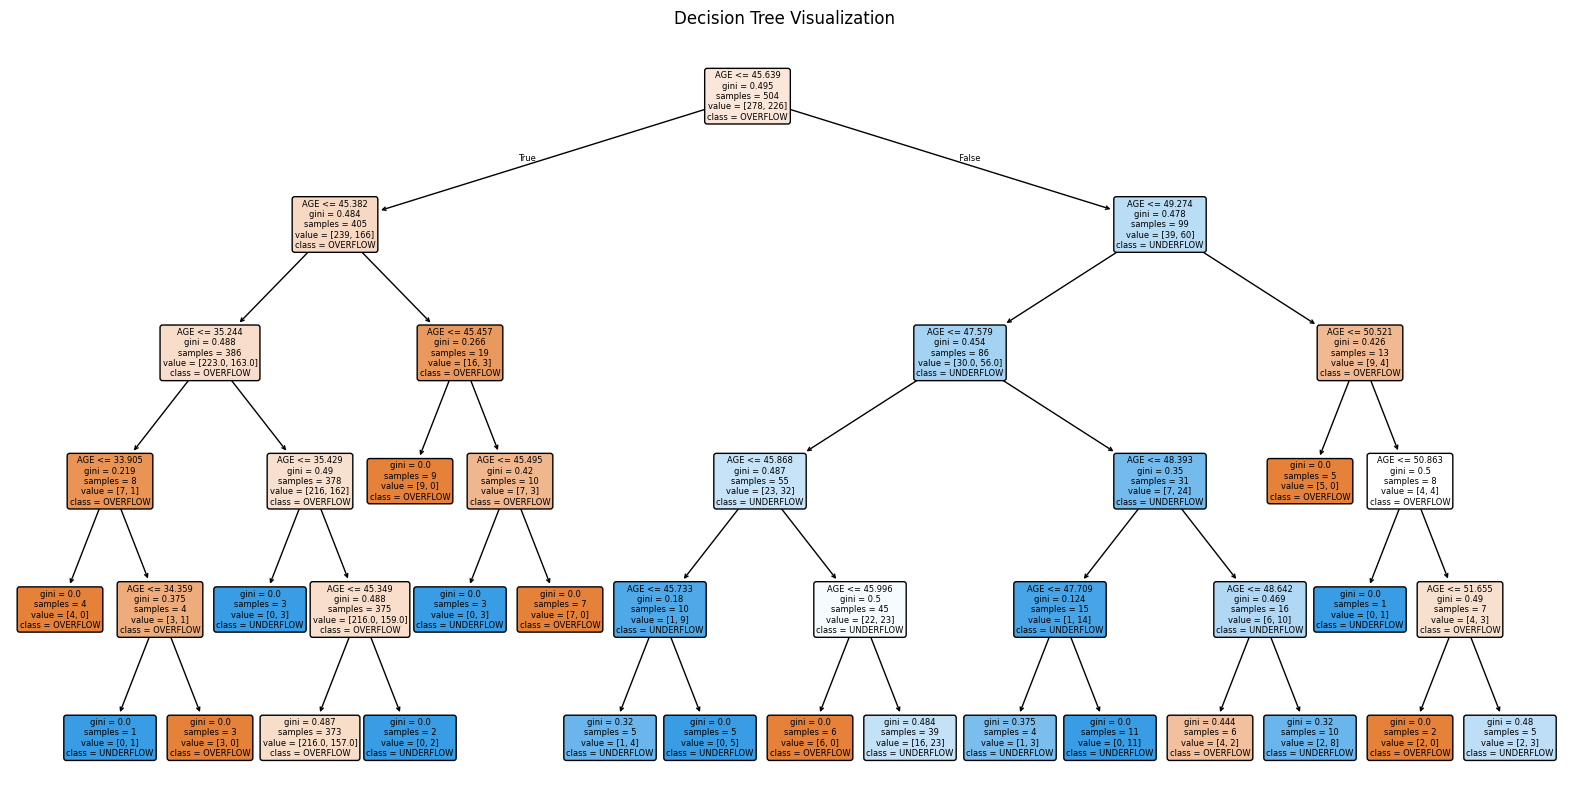

In [5]:
X = df_avg_mode.drop(columns=['STATUS', 'STATION ID', 'DATE', 'INFLOW', 'OUTFLOW', 'NET FLOW'])  # Exclude 'DATE' explicitly
y = df_avg_mode['STATUS']
label_encoders = {}
for column in X.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=[str(cl) for cl in clf.classes_], rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

this code oversamples the training features USER TYPE == CUSTOMER, and also GENDER == Female and tests on original data, this in fact appears in our work

Accuracy on Original Data: 0.64
Classification Report on Original Data:
              precision    recall  f1-score   support

    OVERFLOW       0.63      0.87      0.73       356
   UNDERFLOW       0.66      0.35      0.46       274

    accuracy                           0.64       630
   macro avg       0.65      0.61      0.59       630
weighted avg       0.65      0.64      0.61       630



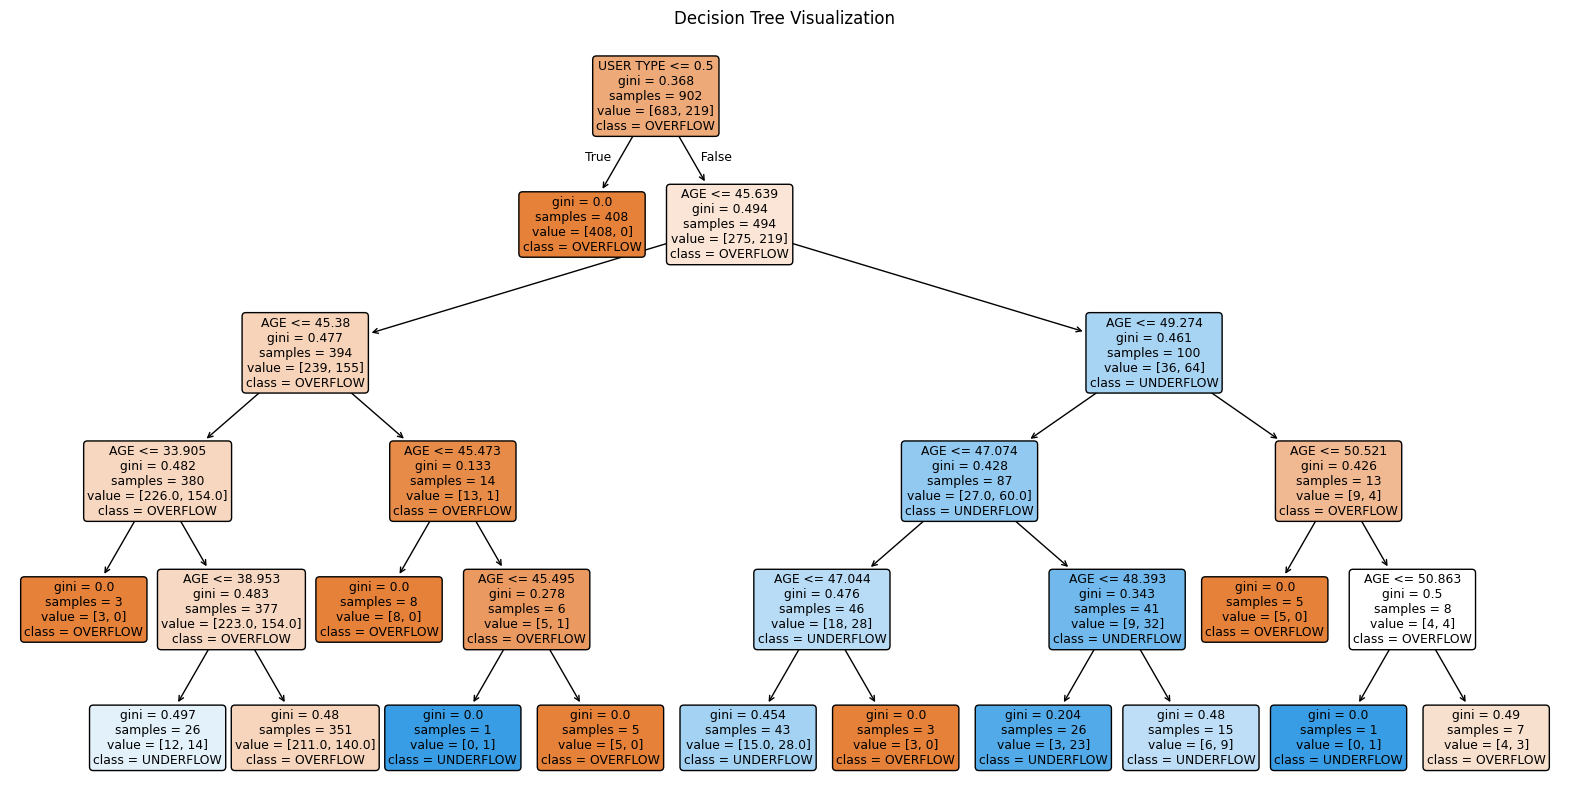

In [6]:
df_majority = df_avg_mode[df_avg_mode['USER TYPE'] == 'Subscriber']
df_minority = df_avg_mode[df_avg_mode['USER TYPE'] == 'Customer']
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=int(len(df_minority) * 250), 
                                 random_state=42)  # arbitrarily set this to get consistency through the different models
df_balanced = pd.concat([df_majority, df_minority_upsampled])
X_balanced = df_balanced.drop(columns=['STATUS', 'STATION ID', 'DATE', 'INFLOW', 'OUTFLOW', 'NET FLOW'])  # Exclude 'DATE' explicitly
y_balanced = df_balanced['STATUS']
X_original = df_avg_mode.drop(columns=['STATUS', 'STATION ID', 'DATE', 'INFLOW', 'OUTFLOW', 'NET FLOW'])
y_original = df_avg_mode['STATUS']
label_encoders = {}
for column in X_balanced.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    X_balanced[column] = le.fit_transform(X_balanced[column])
    X_original[column] = le.transform(X_original[column])  # Apply the same encoding to original data
    label_encoders[column] = le
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
clf_balanced = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_original = clf_balanced.predict(X_original)
accuracy_original = accuracy_score(y_original, y_pred_original)
report_original = classification_report(y_original, y_pred_original)
print(f'Accuracy on Original Data: {accuracy_original:.2f}')
print('Classification Report on Original Data:')
print(report_original)
plt.figure(figsize=(20,10))
plot_tree(clf_balanced, filled=True, feature_names=X_balanced.columns, class_names=clf_balanced.classes_, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


In [24]:
df_majority = df_avg_mode[df_avg_mode['USER TYPE'] == 'Subscriber']
df_minority = df_avg_mode[df_avg_mode['USER TYPE'] == 'Customer']

# Upsample minority class USER TYPE
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(len(df_minority) * 250), 
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Calculate the current distribution of STATUS
current_status_distribution = df_balanced['STATUS'].value_counts(normalize=True)
print("Current STATUS distribution:")
print(current_status_distribution)

# Calculate the desired number of UNDERFLOW cases to reach at least 35%
desired_underflow_proportion = 0.35
current_underflow_count = df_balanced[df_balanced['STATUS'] == 'UNDERFLOW'].shape[0]
total_count = df_balanced.shape[0]
desired_underflow_count = int(desired_underflow_proportion * total_count)

# Calculate how many more UNDERFLOW cases are needed
additional_underflow_needed = max(0, desired_underflow_count - current_underflow_count)

# Perform oversampling if additional UNDERFLOW cases are needed
if additional_underflow_needed > 0:
    underflow_data = df_balanced[df_balanced['STATUS'] == 'UNDERFLOW']
    underflow_oversampled = resample(underflow_data,
                                     replace=True,  # sample with replacement
                                     n_samples=additional_underflow_needed,  # number of additional samples needed
                                     random_state=42)  # reproducible results

    # Combine the oversampled UNDERFLOW cases with the original dataset
    df_balanced = pd.concat([df_balanced, underflow_oversampled])

# Verify the new distribution
new_status_distribution = df_balanced['STATUS'].value_counts(normalize=True) * 100
print("\nNew STATUS distribution after oversampling:")
print(new_status_distribution)

# Prepare the data, excluding the 'DATE' and 'STATION ID' columns
X_balanced = df_balanced.drop(columns=['STATUS', 'STATION ID', 'DATE', 'INFLOW', 'OUTFLOW', 'NET FLOW'])  # Exclude 'DATE' explicitly
y_balanced = df_balanced['STATUS']

# Encode categorical features
label_encoders = {}
for column in X_balanced.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    X_balanced[column] = le.fit_transform(X_balanced[column])
    label_encoders[column] = le

# Split the data into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train the Decision Tree Classifier
clf_balanced = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_balanced = clf_balanced.predict(X_test_balanced)

# Evaluate the model
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
report_balanced = classification_report(y_test_balanced, y_pred_balanced)

# Display results
print(f'Accuracy: {accuracy_balanced:.2f}')
print('Classification Report:')
print(report_balanced)


Current STATUS distribution:
STATUS
OVERFLOW     0.757092
UNDERFLOW    0.242908
Name: proportion, dtype: float64

New STATUS distribution after oversampling:
STATUS
OVERFLOW     68.429487
UNDERFLOW    31.570513
Name: proportion, dtype: float64
Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

    OVERFLOW       0.77      0.92      0.84       182
   UNDERFLOW       0.55      0.26      0.36        68

    accuracy                           0.74       250
   macro avg       0.66      0.59      0.60       250
weighted avg       0.71      0.74      0.71       250



correctly do train test split, with the UNDERFLOW  class

Accuracy on Original Test Data: 0.63
Classification Report on Original Test Data:
              precision    recall  f1-score   support

    OVERFLOW       0.65      0.90      0.75        78
   UNDERFLOW       0.56      0.21      0.30        48

    accuracy                           0.63       126
   macro avg       0.60      0.55      0.53       126
weighted avg       0.61      0.63      0.58       126



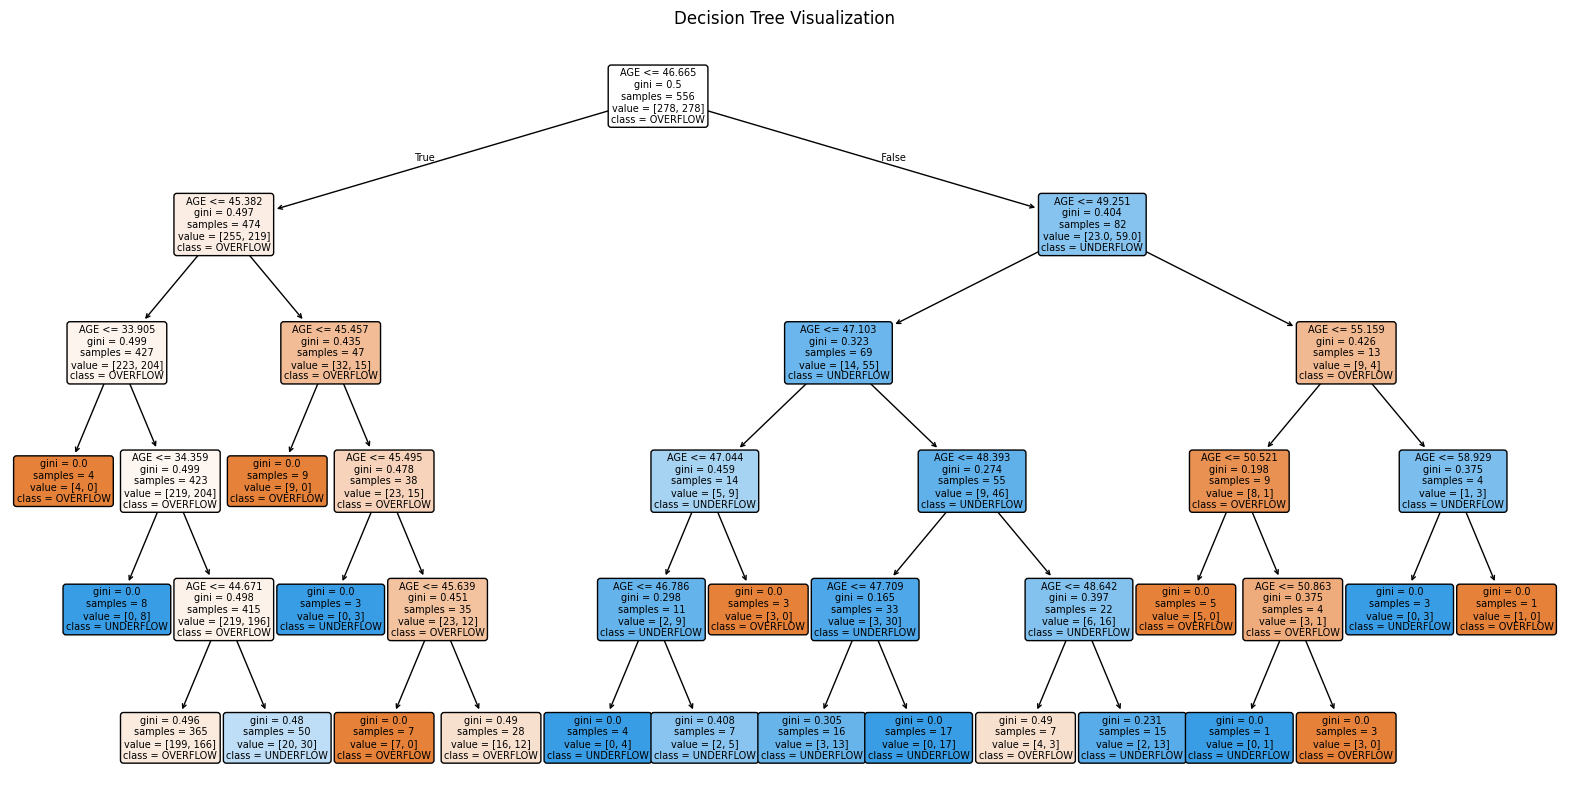

In [10]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

X = df_avg_mode.drop(columns=['STATUS', 'STATION ID', 'DATE', 'INFLOW', 'OUTFLOW', 'NET FLOW'])  
y = df_avg_mode['STATUS']
label_encoders = {}
for column in X.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_majority_train = X_train[y_train == 'OVERFLOW']
df_minority_train = X_train[y_train == 'UNDERFLOW']
y_majority_train = y_train[y_train == 'OVERFLOW']
y_minority_train = y_train[y_train == 'UNDERFLOW']
df_minority_train_upsampled = resample(df_minority_train, 
                                       replace=True,     
                                       n_samples=len(df_majority_train),  # Match the number of majority class samples
                                       random_state=42)
y_minority_train_upsampled = resample(y_minority_train,
                                      replace=True,
                                      n_samples=len(y_majority_train),
                                      random_state=42)
X_train_balanced = pd.concat([df_majority_train, df_minority_train_upsampled])
y_train_balanced = pd.concat([y_majority_train, y_minority_train_upsampled])
X_train_balanced = X_train_balanced.reset_index(drop=True)
y_train_balanced = y_train_balanced.reset_index(drop=True)
clf_balanced = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_test = clf_balanced.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
print(f'Accuracy on Original Test Data: {accuracy_test:.2f}')
print('Classification Report on Original Test Data:')
print(report_test)
plt.figure(figsize=(20,10))
plot_tree(clf_balanced, filled=True, feature_names=X.columns, class_names=clf_balanced.classes_, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


correctly do train test split, with the GENDER + USER TYPE class

Accuracy on Original Test Data: 0.67
Classification Report on Original Test Data:
              precision    recall  f1-score   support

    OVERFLOW       0.69      0.86      0.77        78
   UNDERFLOW       0.62      0.38      0.47        48

    accuracy                           0.67       126
   macro avg       0.66      0.62      0.62       126
weighted avg       0.66      0.67      0.65       126



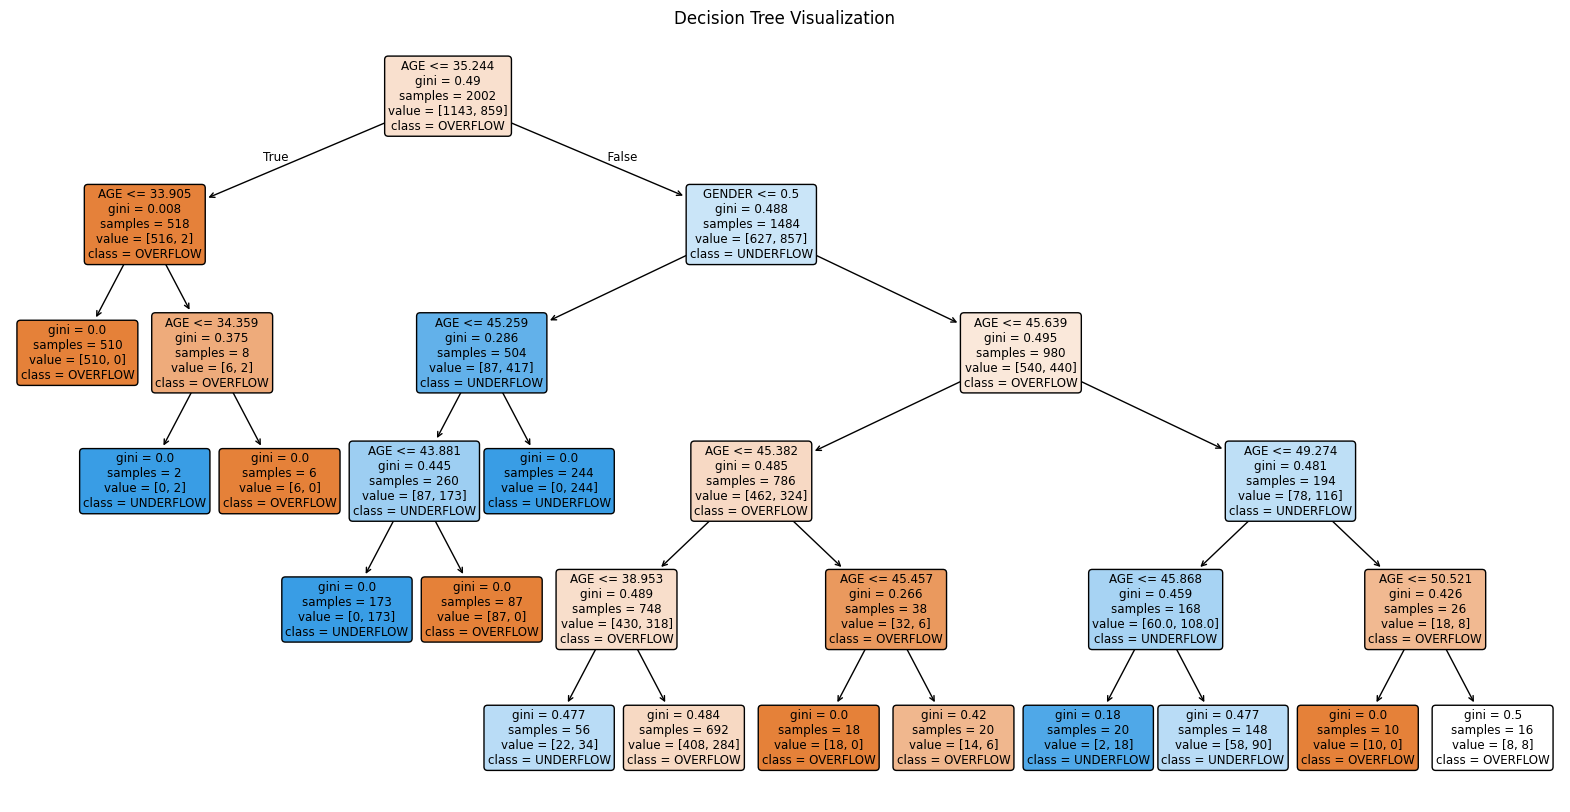

In [12]:
X = df_avg_mode.drop(columns=['STATUS', 'STATION ID', 'DATE', 'INFLOW', 'OUTFLOW', 'NET FLOW'])  
y = df_avg_mode['STATUS']
label_encoders = {}
for column in X.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_male_train = X_train[X_train['GENDER'] == label_encoders['GENDER'].transform(['Male'])[0]]
df_female_train = X_train[X_train['GENDER'] == label_encoders['GENDER'].transform(['Female'])[0]]
df_subscriber_train = X_train[X_train['USER TYPE'] == label_encoders['USER TYPE'].transform(['Subscriber'])[0]]
df_customer_train = X_train[X_train['USER TYPE'] == label_encoders['USER TYPE'].transform(['Customer'])[0]]
y_male_train = y_train[X_train['GENDER'] == label_encoders['GENDER'].transform(['Male'])[0]]
y_female_train = y_train[X_train['GENDER'] == label_encoders['GENDER'].transform(['Female'])[0]]
y_subscriber_train = y_train[X_train['USER TYPE'] == label_encoders['USER TYPE'].transform(['Subscriber'])[0]]
y_customer_train = y_train[X_train['USER TYPE'] == label_encoders['USER TYPE'].transform(['Customer'])[0]]
df_female_train_upsampled = resample(df_female_train, 
                                     replace=True,     
                                     n_samples=len(df_male_train), 
                                     random_state=42)
df_customer_train_upsampled = resample(df_customer_train, 
                                       replace=True,     
                                       n_samples=len(df_subscriber_train),  
                                       random_state=42)
y_female_train_upsampled = resample(y_female_train,
                                    replace=True,
                                    n_samples=len(y_male_train),
                                    random_state=42)
y_customer_train_upsampled = resample(y_customer_train,
                                      replace=True,
                                      n_samples=len(y_subscriber_train),
                                      random_state=42)
X_train_balanced = pd.concat([df_male_train, df_female_train_upsampled, df_subscriber_train, df_customer_train_upsampled])
y_train_balanced = pd.concat([y_male_train, y_female_train_upsampled, y_subscriber_train, y_customer_train_upsampled])
X_train_balanced = X_train_balanced.reset_index(drop=True)
y_train_balanced = y_train_balanced.reset_index(drop=True)
clf_balanced = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_test = clf_balanced.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
print(f'Accuracy on Original Test Data: {accuracy_test:.2f}')
print('Classification Report on Original Test Data:')
print(report_test)
plt.figure(figsize=(20,10))
plot_tree(clf_balanced, filled=True, feature_names=X.columns, class_names=clf_balanced.classes_, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


Visualize the tree

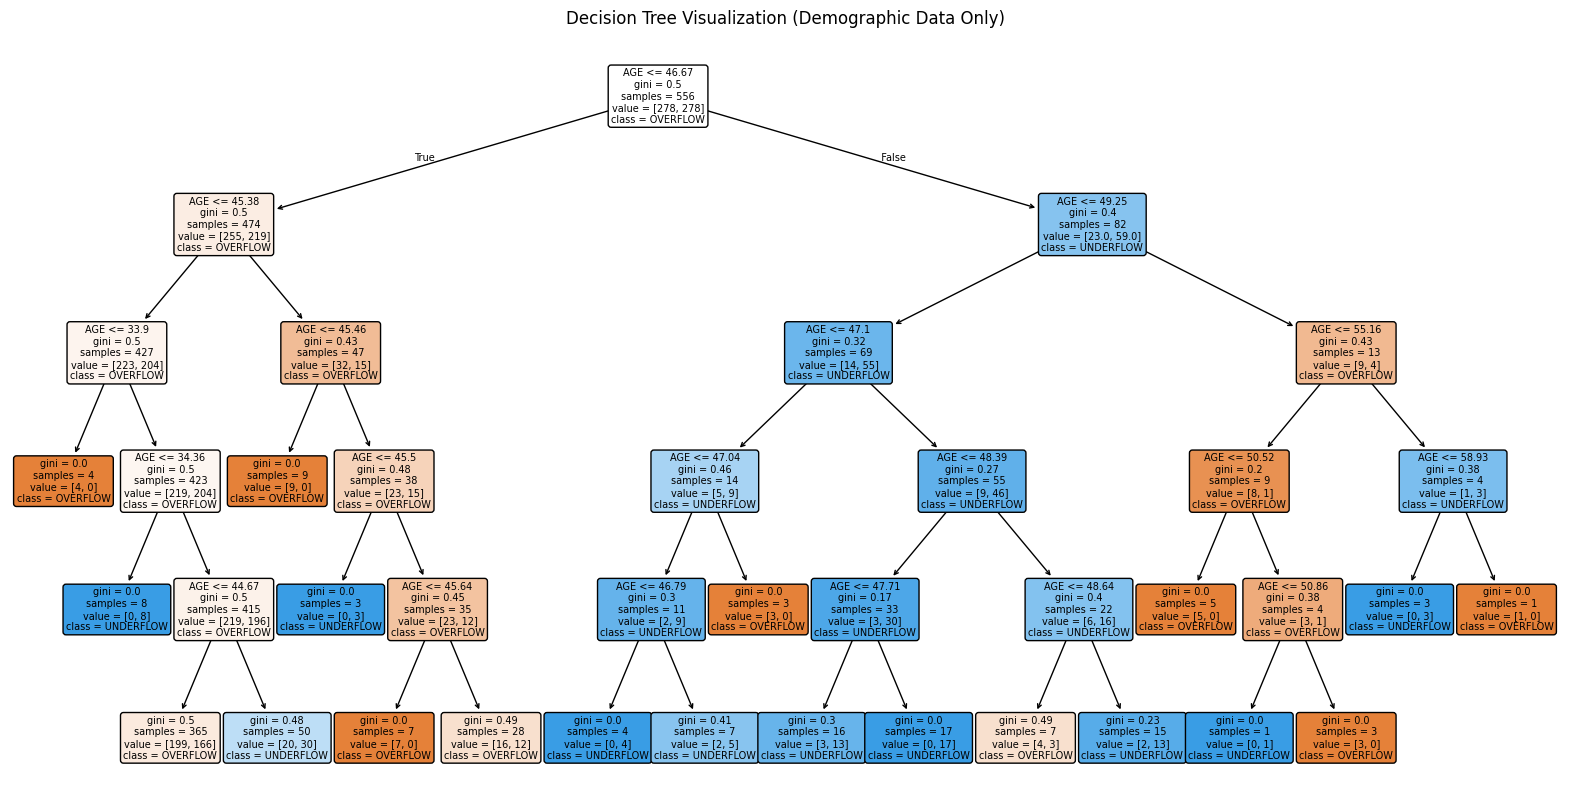

In [11]:
plt.figure(figsize=(20, 10))
plot_tree(clf_balanced, 
          filled=True, 
          feature_names=X_train_balanced.columns, 
          class_names=clf_balanced.classes_, 
          rounded=True, 
          proportion=False, 
          precision=2)
plt.title("Decision Tree Visualization (Demographic Data Only)")
plt.show()
